In [25]:
!wget https://raw.githubusercontent.com/chubby47/SIFT_BOW/master/tools.py
!wget https://raw.githubusercontent.com/chubby47/SIFT_BOW/master/compute_kmeans.py
!wget https://raw.githubusercontent.com/chubby47/SIFT_BOW/master/compute_sifts.py

MessageError: ignored

In [0]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

import numpy as np
from tools import *

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!unzip /content/drive/My\ Drive/data.zip -d /content/

# Partie 1 : SIFT

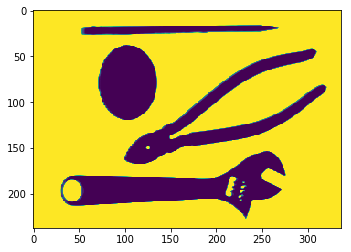

In [27]:
# example images
I = read_grayscale('data/tools.tiff')
I2 = read_grayscale('data/Scene/CALsuburb/image_0205.jpg')
plt.imshow(I)

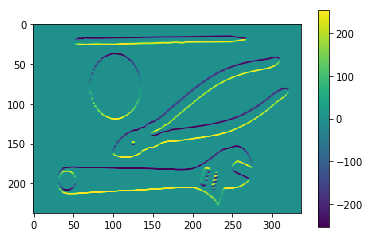

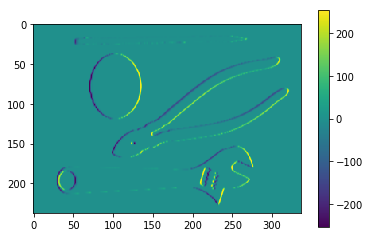

In [28]:
def compute_grad(I):
    h_x = 0.5*np.asarray([1,0,-1])
    h_y = 0.5*np.asarray([-1,-2,-1])
    Iy = conv_separable(I, h_x, h_y)
    Ix = conv_separable(I, h_y, h_x)
    return Ix, Iy

# example d'affichage du résultat
Ix, Iy = compute_grad(I)
plt.imshow(Ix)
plt.colorbar()
plt.show()
plt.imshow(Iy)
plt.colorbar()
plt.show()

In [0]:
def compute_grad_mod_ori(I):
    Ix, Iy = compute_grad(I)
    Gm = np.sqrt(Ix**2+Iy**2)
    Go = compute_grad_ori(Ix, Iy, Gm)
    return Gm, Go

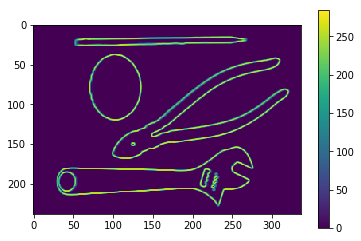

In [30]:
Gm, Go = compute_grad_mod_ori(I)
plt.imshow(Gm)
plt.colorbar()
plt.show()

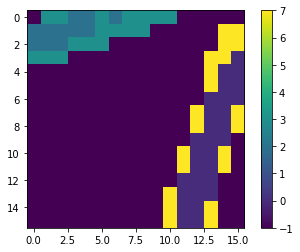

In [0]:
dude = Go[180:180+16,200:200+16]
plt.imshow(dude)
plt.colorbar()
plt.show()

In [0]:
Go = Go[180:180+16,200:200+16]
Gm = Gm[180:180+16,200:200+16]

In [0]:
np.histogram(Go,bins=8)[1]

array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.])

In [0]:
np.digitize( Go,bins=np.histogram(Go,bins=8)[1])-2

array([[-1,  3,  3,  2,  2,  3,  2,  3,  3,  3,  3, -1, -1, -1, -1, -1],
       [ 2,  2,  2,  2,  2,  3,  3,  3,  3, -1, -1, -1, -1, -1,  7,  7],
       [ 2,  2,  2,  3,  3,  3, -1, -1, -1, -1, -1, -1, -1, -1,  7,  7],
       [ 3,  3,  3, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  7,  7,  0],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  7,  0,  0],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  7,  0,  0],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  0,  0],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  7,  0,  0,  7],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  7,  0,  0,  7],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  0,  0, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  7,  0,  0,  7, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  7,  0,  0,  7, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  0,  0, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  7,

In [0]:
i, j = 0, 0
Gn_region = Gm[i*4:i*4+4,j*4:j*4+4]
Go_region = Go[i*4:i*4+4,j*4:j*4+4]

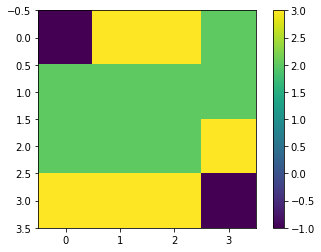

In [19]:
plt.imshow(Go_region)
plt.colorbar()
plt.show()

In [20]:
Go_region

array([[-1,  3,  3,  2],
       [ 2,  2,  2,  2],
       [ 2,  2,  2,  3],
       [ 3,  3,  3, -1]])

In [23]:
Gn_region

array([[  0.        ,  25.10229073,  95.63080048, 176.63415581],
       [194.73122503, 242.99176941, 270.45632734, 267.06225866],
       [262.18504915, 240.45087856, 178.16004041,  92.0142652 ],
       [ 70.00178569,  20.93442142,   1.76776695,   0.        ]])

In [24]:
ind = np.where(Go_region==3)
np.sum(Gn_region[ind[0],ind[1]])

305.4513304681187

In [0]:
def compute_sift_region(Gm, Go, mask=None):
    # Note: to apply the mask only when given, do:
    R = np.zeros((16,8))
    Gn = Gm.copy()
    if mask is not None:
        Gn = np.multiply(Gn, mask)
    for i in range(4):
        for j in range(4):
            Gn_region = Gn[i*4:i*4+4,j*4:j*4+4]
            Go_region = Go[i*4:i*4+4,j*4:j*4+4]
            #Go_region = np.digitize( Go_region,bins=np.histogram(Go_region,bins=8)[1])-2
            for v in range(8):
                ind = np.where(Go_region==v)
                s = np.sum(Gn_region[ind[0],ind[1]])
                R[i*4+j][v] = s
    sift = R.ravel()
    norm = np.linalg.norm(sift)
    if norm < 0.5:
        return np.zeros(sift.shape)
    sift = sift/np.linalg.norm(sift, ord=1)
    sift = np.clip(sift,0,0.2)
    sift = sift/np.linalg.norm(sift, ord=1)
    return sift

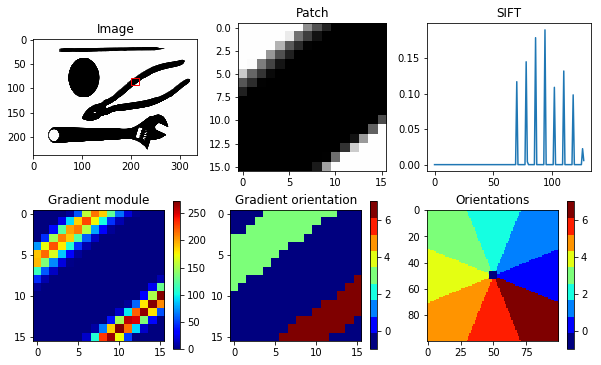

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.11663215, 0.        , 0.        , 0.        , 0.     

In [40]:
display_sift_region(I, compute_grad_mod_ori, compute_sift_region, gausm=True)

In [0]:
# Example of viz of SIFTs
# set gausm to True to apply mask weighting of gradients
#display_sift_region(I,           compute_grad_mod_ori, compute_sift_region, x=200, y=78, gausm=False)
#display_sift_region(marche_im(), compute_grad_mod_ori, compute_sift_region, x=100, y=125, gausm=False)
#display_sift_region(marche_im(), compute_grad_mod_ori, compute_sift_region, x=100, y=125, gausm=False)
#display_sift_region(marche_im(), compute_grad_mod_ori, compute_sift_region, x=125, y=100, gausm=False)
#display_sift_region(marche_im(), compute_grad_mod_ori, compute_sift_region, x=121, y=121, gausm=False)
#display_sift_region(toy_im(),    compute_grad_mod_ori, compute_sift_region, x=95, y=95, gausm=False)

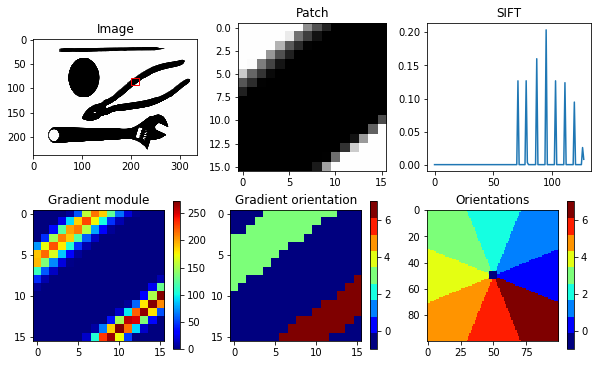

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.12674949, 0.        , 0.        , 0.     

In [11]:
display_sift_region(I,           compute_grad_mod_ori, compute_sift_region, x=200, y=78, gausm=False)

In [0]:
def compute_sift_image(I):
    x, y = dense_sampling(I)
    im = auto_padding(I)
    
    # TODO calculs communs aux patchs
    sifts = np.zeros(len(x), len(y), 128)
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            sifts[i, j, :] = None # TODO SIFT du patch de coordonnee (xi, yj)
    return sifts

# Partie 2 : Dictionnaire visuel

In [0]:
# Ideally, restart the Python kernel to start from a clean slate
import os
import numpy as np
from tools import *
from sift import *

In [0]:
# Paths config
dir_sc = os.path.join('data', 'Scene')
dir_sift = os.path.join('data', 'sift')
path_vdict = os.path.join('data', 'kmeans', 'vdict.npy')
path_vdsift = os.path.join('data', 'kmeans', 'vdsift.npy')
path_vdinames = os.path.join('data', 'kmeans', 'vdinames.npy')

inames, ilabls, cnames = load_dataset(dir_sc)

In [0]:
# If you want to look at the SIFTs that will be fed to compute_visual_dict:
sifts_list_by_image = compute_load_sift_dataset(dir_sc, dir_sift, inames, compute_sift_image)

In [0]:
# Code here the `compute_visual_dict` function
def compute_visual_dict(sift, n_clusters=1000, n_init=1, verbose=1):
    # reorder data
    dim_sift = sift[0].shape[-1]
    sift = [s.reshape(-1, dim_sift) for s in sift]
    sift = np.concatenate(sift, axis=0)
    # remove zero vectors
    keep = ~np.all(sift==0, axis=1)
    sift = sift[keep]
    # randomly pick sift
    ids, _ = compute_split(sift.shape[0], pc=0.05)
    sift = sift[ids]
    
    # TODO compute kmeans on `sift`, get cluster centers, add zeros vector

In [0]:
# Run the visual dict computation (saved the first time)
vidct = compute_or_load_vdict(dir_sc, dir_sift, inames, compute_sift_image, path_vdict, compute_visual_dict)

In [0]:
# Study of the dict
regions, sifts = get_regions_and_sifts(dir_sc, np.random.choice(inames, 30)) # Compute SIFT and regions from 30 random images
display_images(regions[np.random.choice(len(regions), 100)]) # Show 100 random regions

# TODO visually analyze the dict through similar example regions
#
# Ideally, create `vdregions`, a numpy array of size 1001 x 16 x 16 where each of the 1001 elements is a
# "prototype" patch that is very close to the cluster center

# Partie 3 : BoW

In [0]:
# Compute BoW for an image

def compute_feats(vdict, image_sifts):
    # TODO compute BoW from `image_sifts`
    return

In [0]:
# Visualize your BoW on an image

iname = inames[0]
ipath = os.path.join(dir_sc, iname)
im = read_grayscale(ipath)
sift = compute_sift_image(im)
regions = compute_regions(im)
feats = compute_feats(vdict, sift)

display_vdregions_image(im, vdict, sift, feats, vdregions=None) # if you have vdregions, add it as input here